## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Getting the Data

In [2]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2022-6-1')['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
#target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier with random portfolios

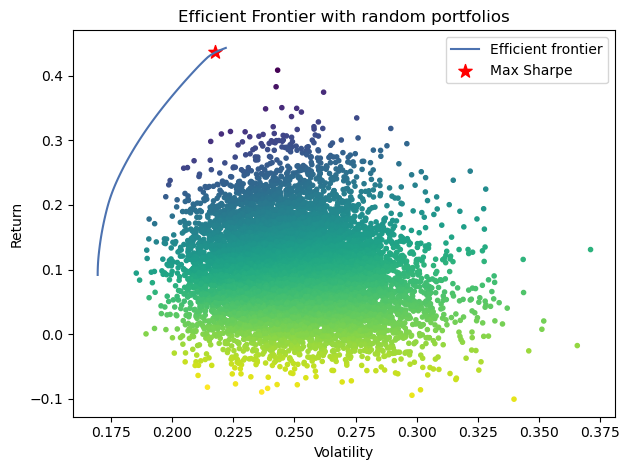

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
#plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [5]:
# Optimize for maximum Sharpe ratio

#weights = ef.max_sharpe()

#  print weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.19874), ('AMD', 0.0), ('BA', 0.20002), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.20002), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.0), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.20001), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.00132)])


In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef.portfolio_performance(verbose=True)

Expected annual return: 44.3%
Annual volatility: 22.2%
Sharpe Ratio: 1.90


(0.44270301942915596, 0.22195343264669998, 1.9044671415467778)

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=30000)
allocation, leftover = da.lp_portfolio()

C:\Users\ruchd\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [8]:
print("Optimal Allocation:", allocation)

Optimal Allocation: {'AAPL': 32, 'BA': 27, 'GE': 56, 'SBUX': 59, 'WMT': 39}


## Markowitz with Target Volatility

In [9]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data
target_volatility = 0.2


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

ef_tv.efficient_risk(target_volatility)

OrderedDict([('AAPL', 0.033124679484351),
             ('AMD', 1.76419e-11),
             ('BA', 0.1618087875119898),
             ('BABA', 2.57702e-11),
             ('BAC', 2.57221e-11),
             ('GE', 0.1999999999764412),
             ('GM', 1.36447e-11),
             ('GOOG', 6.94531e-11),
             ('JPM', 0.0090315347087253),
             ('MU', 1.73291e-11),
             ('PFE', 0.0832956715414506),
             ('RRC', 1.39414e-11),
             ('SBUX', 0.1999999998150859),
             ('T', 0.0208296363751433),
             ('UAA', 1.3918e-12),
             ('WMT', 0.1999999999752445),
             ('XOM', 0.0919096904261977)])

In [10]:
#  print weights
cleaned_weights_tv = ef_tv.clean_weights()
print(cleaned_weights_tv)

OrderedDict([('AAPL', 0.03312), ('AMD', 0.0), ('BA', 0.16181), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.00903), ('MU', 0.0), ('PFE', 0.0833), ('RRC', 0.0), ('SBUX', 0.2), ('T', 0.02083), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.09191)])


In [11]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

Expected annual return: 36.8%
Annual volatility: 20.0%
Sharpe Ratio: 1.74


(0.36833013193519143, 0.20000000008982885, 1.7416506588937046)

In [12]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights_tv, latest_prices, total_portfolio_value=30000)
allocation_tv, leftover = da.lp_portfolio()

In [13]:
print("Optimal Allocation:", allocation_tv)

Optimal Allocation: {'AAPL': 5, 'BA': 22, 'GE': 56, 'JPM': 2, 'PFE': 62, 'SBUX': 59, 'T': 39, 'WMT': 39, 'XOM': 26}


## Markowitz with Monthly Rebalancing keeping Original Weights Only

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

In [14]:
prices = historical_prices.groupby(pd.Grouper(freq='M'))
print(prices)

# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 30000

# Set rebalancing frequency (in months)
rebalancing_frequency = 1

# Iterate over each month
for i in range(1, len(historical_prices.groupby(pd.Grouper(freq='M'))), rebalancing_frequency):
    # Get historical prices for the current month
    prices = historical_prices.groupby(pd.Grouper(freq='M')).iloc[i]

    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    latest_prices = prices.iloc[-1]  # Latest prices for the assets
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, _ = da.lp_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(allocation, ignore_index=True)
    print(allocation_history)

# Print the allocation history
